In [205]:
import os
import importlib.util

# Define the path to config.py
config_path = os.path.abspath(os.path.join(os.path.dirname(r'C:\Users\nilay\OneDrive - Cal State Fullerton (1)\Desktop\NILAY-TO-JOB-DATA\SPRING 2024\CPSC 597 Project\Stock-Price-Prediction'), 'Stock-Price-Prediction', 'config.py'))

# Load the module from the specified path
spec = importlib.util.spec_from_file_location("config", config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [206]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

file_path = os.path.join(config.BASE_DIR, 'dataset', 'preprocessed_data', 'AAPL.csv')
df = pd.read_csv(file_path)
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# Convert date from string to datetime
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')
df.dropna(axis=0, inplace=True)

# Initialize scalers for each column
scalers = {
    'Open': MinMaxScaler(),
    'High': MinMaxScaler(),
    'Low': MinMaxScaler(),
    'Close': MinMaxScaler()
}

# Scale each column separately
for column in ['Open', 'High', 'Low', 'Close']:
    df[column] = scalers[column].fit_transform(df[[column]])


In [207]:
import pandas as pd
import numpy as np
import datetime

# Redefine str_to_datetime function to handle different date formats if needed
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Function to create a windowed dataframe
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X_open, X_high, X_low, X_close, Y_open, Y_high, Y_low, Y_close = [], [], [], [], [], [], [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        open_values = df_subset['Open'].to_numpy()
        high_values = df_subset['High'].to_numpy()
        low_values = df_subset['Low'].to_numpy()
        close_values = df_subset['Close'].to_numpy()

        X_open.append(open_values[:-1])
        Y_open.append(open_values[-1])
        
        X_high.append(high_values[:-1])
        Y_high.append(high_values[-1])
        
        X_low.append(low_values[:-1])
        Y_low.append(low_values[-1])
        
        X_close.append(close_values[:-1])
        Y_close.append(close_values[-1])

        dates.append(target_date)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    data = {
        'Target Date': dates
    }

    X_open = np.array(X_open)
    X_high = np.array(X_high)
    X_low = np.array(X_low)
    X_close = np.array(X_close)

    for i in range(n):
        data[f'Open-{n-i}'] = X_open[:, i]
        data[f'High-{n-i}'] = X_high[:, i]
        data[f'Low-{n-i}'] = X_low[:, i]
        data[f'Close-{n-i}'] = X_close[:, i]

    data['Open-Target'] = Y_open
    data['High-Target'] = Y_high
    data['Low-Target'] = Y_low
    data['Close-Target'] = Y_close

    ret_df = pd.concat({key: pd.Series(value) for key, value in data.items()}, axis=1)

    return ret_df

# Start day second time around: 1990-01-02 -- 2006-12-29
windowed_df = df_to_windowed_df(df, 
                                '2016-06-10', 
                                '2024-05-31',
                                n=50)
windowed_df


,Target Date,Open-50,High-50,Low-50,Close-50,Open-49,High-49,Low-49,Close-49,Open-48,...,Low-2,Close-2,Open-1,High-1,Low-1,Close-1,Open-Target,High-Target,Low-Target,Close-Target
0,2016-06-10,0.125863,0.124575,0.127592,0.125558,0.124783,0.124689,0.126794,0.126712,0.126668,...,0.115618,0.113959,0.112969,0.113322,0.115359,0.114778,0.113004,0.112595,0.115383,0.113832
1,2016-06-13,0.124783,0.124689,0.126794,0.126712,0.126668,0.127176,0.129224,0.128016,0.125622,...,0.115359,0.114778,0.113004,0.112595,0.115383,0.113832,0.113187,0.112334,0.113763,0.112112
2,2016-06-14,0.126668,0.127176,0.129224,0.128016,0.125622,0.125518,0.128226,0.126504,0.126449,...,0.115383,0.113832,0.113187,0.112334,0.113763,0.112112,0.111613,0.111607,0.113352,0.112251
3,2016-06-15,0.125622,0.125518,0.128226,0.126504,0.126449,0.125802,0.127968,0.127831,0.126128,...,0.113763,0.112112,0.111613,0.111607,0.113352,0.112251,0.112188,0.111528,0.113681,0.111882
4,2016-06-16,0.126449,0.125802,0.127968,0.127831,0.126128,0.125166,0.126700,0.125038,0.124932,...,0.113352,0.112251,0.112188,0.111528,0.113681,0.111882,0.110613,0.110778,0.112554,0.112355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,2024-05-24,0.794613,0.791552,0.807702,0.798404,0.786614,0.783875,0.799437,0.796649,0.806840,...,0.893262,0.881036,0.877678,0.867363,0.876169,0.862479,0.867749,0.865456,0.882790,0.876789
2003,2024-05-28,0.786614,0.783875,0.799437,0.796649,0.806840,0.806996,0.814605,0.801727,0.801186,...,0.876169,0.862479,0.867749,0.865456,0.882790,0.876789,0.880114,0.876448,0.887768,0.876836
2004,2024-05-29,0.806840,0.806996,0.814605,0.801727,0.801186,0.801999,0.812304,0.812622,0.807530,...,0.882790,0.876789,0.880114,0.876448,0.887768,0.876836,0.871380,0.873041,0.889693,0.878220
2005,2024-05-30,0.801186,0.801999,0.812304,0.812622,0.807530,0.811356,0.821978,0.824578,0.813644,...,0.887768,0.876836,0.871380,0.873041,0.889693,0.878220,0.876667,0.872723,0.894952,0.882837


In [208]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    # Extract the features (Open, High, Low, Close) from the columns
    middle_matrix = df_as_np[:, 1:-4]
    # Reshape the features matrix to include the multiple feature sets
    # Each row has n Open, High, Low, and Close values
    num_features = 4  # We have Open, High, Low, Close
    n = (middle_matrix.shape[1] // num_features)  # Number of time steps (n=3 in this case)
    X = middle_matrix.reshape((len(dates), n, num_features))

    # Extract the target values (Open-Target, High-Target, Low-Target, Close-Target)
    Y_open = df_as_np[:, -4]
    Y_high = df_as_np[:, -3]
    Y_low = df_as_np[:, -2]
    Y_close = df_as_np[:, -1]

    # Combine all target values into a single array
    Y = np.stack((Y_open, Y_high, Y_low, Y_close), axis=-1)

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2007,), (2007, 50, 4), (2007, 4))

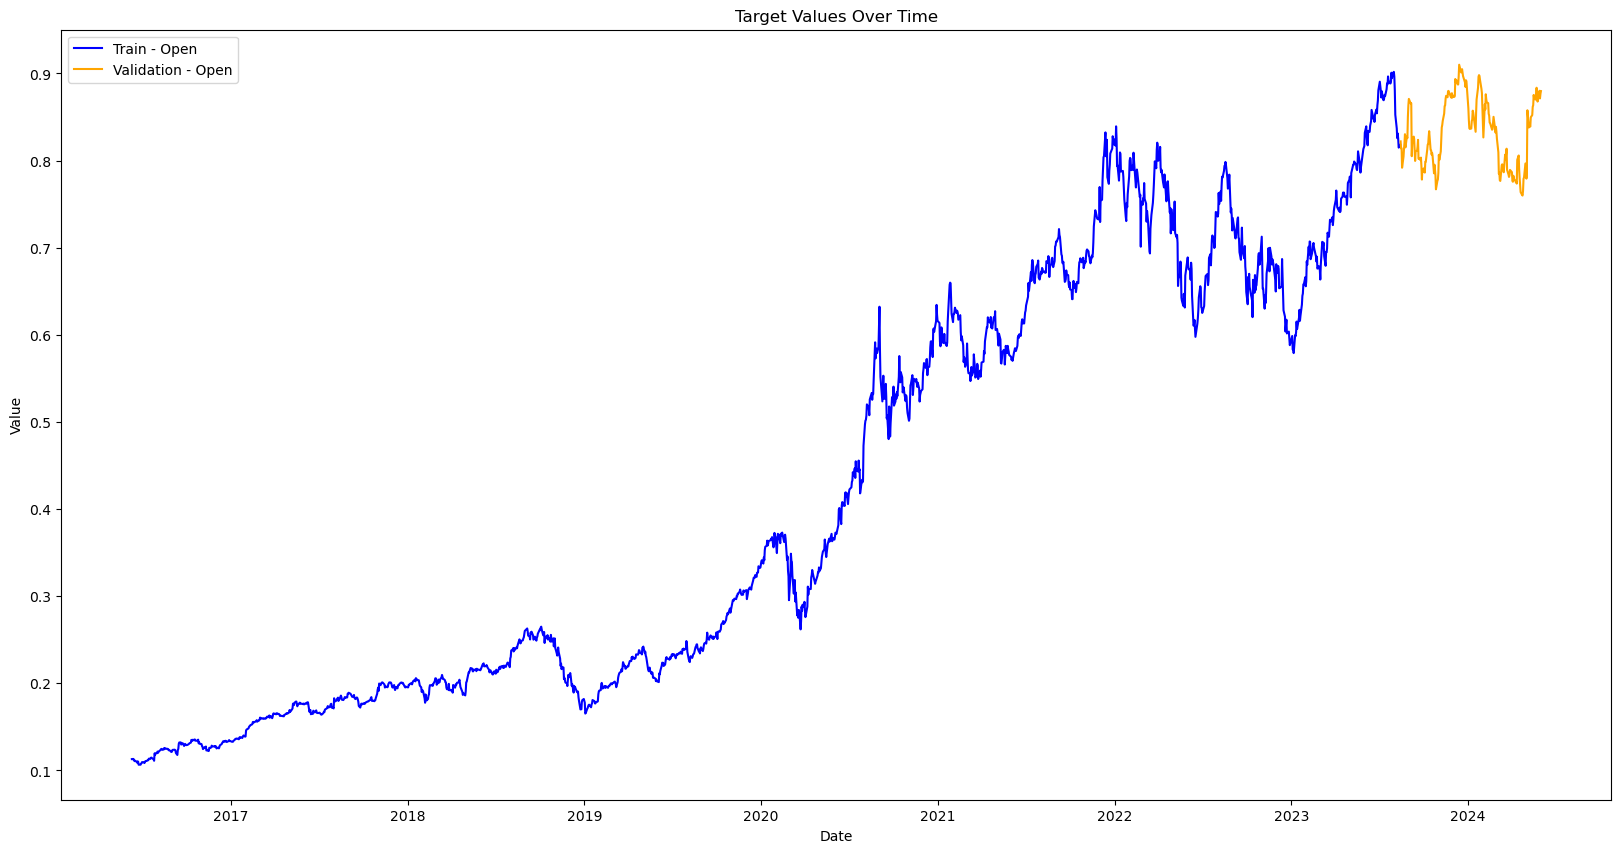

In [209]:
import matplotlib.pyplot as plt

q_80 = int(len(dates) * .80)
q_90 = int(len(dates) * .90)

dates_train2, X_train2, y_train2 = dates[:q_90], X[:q_90], y[:q_90]
dates_val2, X_val2, y_val2 = dates[q_90:], X[q_90:], y[q_90:]
# dates_test2, X_test2, y_test2 = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(20, 10))

# Plotting target values for each feature set
plt.plot(dates_train2, y_train2[:, 0], label='Train - Open', color='blue')
plt.plot(dates_val2, y_val2[:, 0], label='Validation - Open', color='orange')
# plt.plot(dates_test2, y_test2[:, 0], label='Test - Open', color='green')

plt.legend()
plt.title('Target Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

In [210]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model_2 = Sequential([
    layers.Input((3, 4)),
    layers.LSTM(256),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(4)
])

# Compile the model
model_2.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

# Train the model with early stopping
model_2.fit(X_train2, y_train2, 
          validation_data=(X_val2, y_val2), 
          epochs=100, 
          callbacks=[early_stopping])


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - loss: 0.1509 - mean_absolute_error: 0.3102 - val_loss: 0.0076 - val_mean_absolute_error: 0.0688
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.0011 - mean_absolute_error: 0.0237 - val_loss: 0.0011 - val_mean_absolute_error: 0.0275
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 6.2993e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0011 - val_mean_absolute_error: 0.0260
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - loss: 6.0779e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0011 - val_mean_absolute_error: 0.0259
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 5.9331e-04 - mean_absolute_error: 0.0176 - val_loss: 9.0872e-04 - val_mean_absolute_error: 0.0248
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - loss: 5.6361e-04 - mean_absolute_error: 0.0167 - val_loss: 8.3268e-04 - val_mean_absolute_error: 0.0251
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 5.4766

In [211]:
# Cell-5 (updated): Set date range for prediction using dataset dates
import pandas as pd
import datetime

# Redefine str_to_datetime function to handle different date formats if needed
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Extract the dates from the dataset for the prediction range
start_date_str = '2024-06-03'
end_date_str = '2024-06-27'
start_date = str_to_datetime(start_date_str)
end_date = str_to_datetime(end_date_str)

# Create a range of business days for the prediction range using the dataset
dates_set_future_prediction = df.loc[start_date:end_date].index

print(dates_set_future_prediction.shape)
dates_set_future_prediction

(18,)


DatetimeIndex(['2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06',
               '2024-06-07', '2024-06-10', '2024-06-11', '2024-06-12',
               '2024-06-13', '2024-06-14', '2024-06-17', '2024-06-18',
               '2024-06-20', '2024-06-21', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [215]:
# Cell-6 (updated): Predict future stock prices using the model and the dataset dates
input_window = df.loc[:start_date].tail(50).values.reshape(1, 50, 4)  # Get the last 50 days as the initial input window
test_set_future_prediction = []

for date in dates_set_future_prediction:
    current_input = input_window
    prediction = model_2.predict(current_input)
    test_set_future_prediction.append(prediction[0])
    input_window = np.append(input_window[:, 1:, :], [prediction], axis=1)

# Inverse scale the predictions
test_set_future_prediction = np.array(test_set_future_prediction)

inverse_predictions = {
    'Open': scalers['Open'].inverse_transform(test_set_future_prediction[:, 0].reshape(-1, 1)).flatten(),
    'High': scalers['High'].inverse_transform(test_set_future_prediction[:, 1].reshape(-1, 1)).flatten(),
    'Low': scalers['Low'].inverse_transform(test_set_future_prediction[:, 2].reshape(-1, 1)).flatten(),
    'Close': scalers['Close'].inverse_transform(test_set_future_prediction[:, 3].reshape(-1, 1)).flatten()
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [216]:
test_set_future_prediction

array([[0.88832814, 0.8801385 , 0.89611715, 0.88046926],
       [0.8888134 , 0.88150793, 0.89660513, 0.88131946],
       [0.8892154 , 0.8825954 , 0.89691406, 0.8820628 ],
       [0.88951534, 0.88347936, 0.89713997, 0.8826214 ],
       [0.88971484, 0.8841742 , 0.8972736 , 0.8830202 ],
       [0.8898271 , 0.88470185, 0.89732313, 0.8832853 ],
       [0.889863  , 0.885081  , 0.89729553, 0.88343656],
       [0.88983124, 0.8853298 , 0.8971976 , 0.88349247],
       [0.88973284, 0.885461  , 0.89703166, 0.8834601 ],
       [0.88957465, 0.8854885 , 0.89680445, 0.8833523 ],
       [0.88936526, 0.885427  , 0.8965236 , 0.8831809 ],
       [0.8891107 , 0.8852882 , 0.8961973 , 0.8829559 ],
       [0.8888137 , 0.8850813 , 0.8958288 , 0.8826815 ],
       [0.8884826 , 0.8848177 , 0.89542675, 0.88236886],
       [0.8881106 , 0.884499  , 0.89498603, 0.88201225],
       [0.8876996 , 0.88413095, 0.89450955, 0.8816156 ],
       [0.8872692 , 0.88372904, 0.8940154 , 0.88119733],
       [0.88682735, 0.88330173,

In [213]:
# Cell-7 (unchanged): Inverse transform the actual values for comparison
def inverse_transform(scaler, data):
    data = data.reshape(-1, 1)
    return scaler.inverse_transform(data).reshape(-1)

actual_open_prices = inverse_transform(scalers['Open'], df.loc[start_date:end_date, 'Open'].values)
actual_high_prices = inverse_transform(scalers['High'], df.loc[start_date:end_date, 'High'].values)
actual_low_prices = inverse_transform(scalers['Low'], df.loc[start_date:end_date, 'Low'].values)
actual_close_prices = inverse_transform(scalers['Close'], df.loc[start_date:end_date, 'Close'].values)

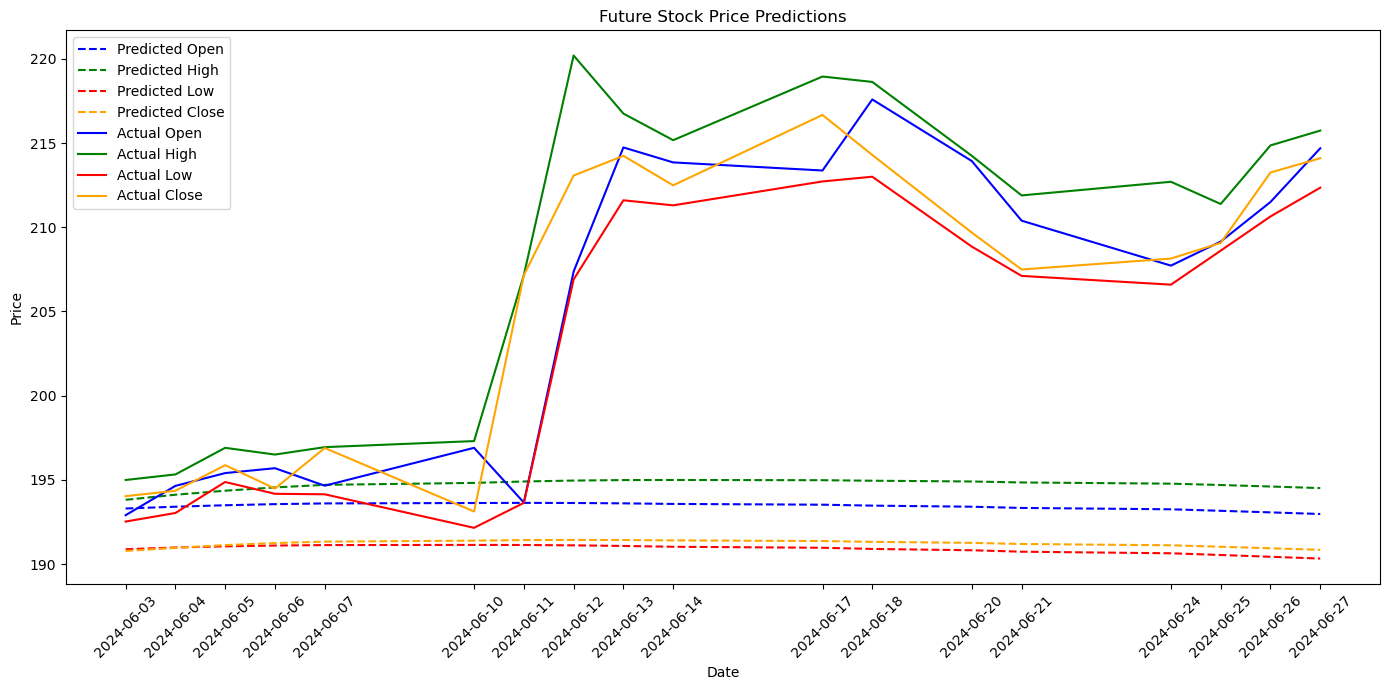

In [219]:
# Cell-8 (unchanged): Plot predicted vs actual values
import matplotlib.pyplot as plt

# Extract inverse-scaled prices
open_prices = inverse_predictions['Open']
high_prices = inverse_predictions['High']
low_prices = inverse_predictions['Low']
close_prices = inverse_predictions['Close']

plt.figure(figsize=(14, 7))

plt.plot(dates_set_future_prediction, open_prices, label='Predicted Open', color='blue', linestyle='dashed')
plt.plot(dates_set_future_prediction, high_prices, label='Predicted High', color='green', linestyle='dashed')
plt.plot(dates_set_future_prediction, low_prices, label='Predicted Low', color='red', linestyle='dashed')
plt.plot(dates_set_future_prediction, close_prices, label='Predicted Close', color='orange', linestyle='dashed')

plt.plot(dates_set_future_prediction, actual_open_prices, label='Actual Open', color='blue')
plt.plot(dates_set_future_prediction, actual_high_prices, label='Actual High', color='green')
plt.plot(dates_set_future_prediction, actual_low_prices, label='Actual Low', color='red')
plt.plot(dates_set_future_prediction, actual_close_prices, label='Actual Close', color='orange')

plt.title('Future Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(dates_set_future_prediction, rotation=45)
plt.tight_layout()
plt.show()